In [1]:
import sys

sys.path.append("..")
import jabble.model
import jabble.dataset
import jabble.loss
import jabble.physics 
import astropy.units as u

import h5py
import matplotlib.pyplot as plt
import scipy.optimize

from jaxopt import GaussNewton
import jax.numpy as jnp
import jax
import numpy as np
from mpl_axes_aligner import align
import os
import jabble.physics

from jax.config import config

config.update("jax_enable_x64", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:174: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/state/partition1/job-41790891/ipykernel_3280096/2272813527.py:22: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
import os
import datetime

today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%y-%m-%d"))
os.makedirs(out_dir,exist_ok=True)

In [3]:
file_b = h5py.File("../data/barnards_e2ds.hdf5", "r")
file_p = h5py.File("../data/51peg_e2ds.hdf5", "r")

In [4]:
file_p.keys()

<KeysViewHDF5 ['airms', 'bervs', 'data', 'dates', 'drifts', 'filelist', 'ivars', 'pipeline_rvs', 'pipeline_sigmas', 'xs']>

In [5]:
xs = np.array(file_p['xs'])
for iii in range(xs.shape[0]):
    print(iii,np.exp(np.min(xs[iii,:,:])),np.exp(np.max(xs[iii,:,:])))

0 3779.5583496093723 3821.963623046875
1 3803.171386718751 3845.851074218753
2 3827.0847167968723 3870.035644531249
3 3851.300781249998 3894.526855468747
4 3875.824462890625 3919.3291015625
5 3900.663574218752 3944.449707031248
6 3925.822753906249 3969.8942871093777
7 3951.308593750002 3995.669921874998
8 3977.1274414062486 4021.781494140622
9 4003.286376953125 4048.237304687499
10 4029.790771484372 4075.0432128906227
11 4056.6481933593764 4102.206542968748
12 4083.8676757812495 4129.734374999999
13 4111.453613281247 4157.634277343746
14 4139.415527343749 4185.913085937502
15 4167.760253906249 4214.579589843752
16 4196.495605468748 4243.642089843752
17 4225.629394531251 4273.107421874997
18 4255.171386718754 4302.984863281254
19 4285.128906249996 4333.283203125002
20 4315.512207031251 4364.011230468748
21 4346.328613281249 4395.177734374996
22 4377.588378906246 4426.792968750001
23 4409.30126953125 4458.865722656248
24 4441.477539062497 4491.407714843752
25 4474.125488281247 4524.42724

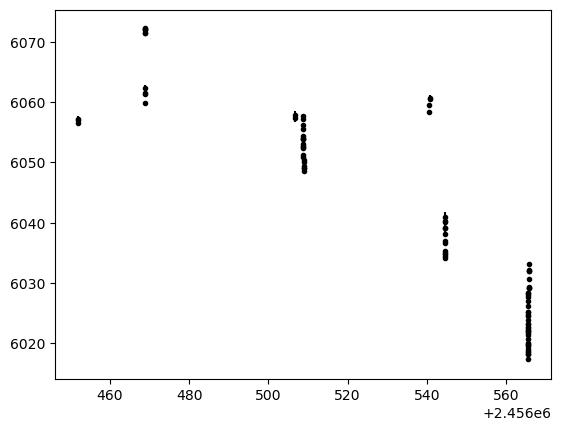

In [6]:
plt.errorbar(
    file_p["dates"][:],
    file_p["pipeline_rvs"][:] + file_p["bervs"][:],
    yerr=file_p["pipeline_sigmas"][:],
    fmt=".k",
)
# plt.errorbar(file['dates'][:],file['bervs'][:],yerr=file['pipeline_sigmas'][:],fmt='.k')
# plt.errorbar(file['dates'][:],file['pipeline_rvs'][:],yerr=file['pipeline_sigmas'][:],fmt='.k')
# plt.errorbar(file['dates'][:],file['drifts'][:],yerr=file['pipeline_sigmas'][:],fmt='.k')
plt.show()

In [7]:
file_p["data"]

<HDF5 dataset "data": shape (72, 91, 4096), type "<f8">

In [8]:
TF_CPP_MIN_LOG_LEVEL = 0

Ask NYU IT about overleaf pro version

In [9]:
def get_dataset(file,order_number,start_index,end_index,gpu=None):
    flux = np.swapaxes(jnp.array(file["data"], dtype=np.float64), 0, 1)
    # flux = flux.reshape(np.product(flux.shape[1]),-1)
    print(flux.shape)
    
    xs = np.swapaxes(jnp.array(file["xs"]), 0, 1)
    # xs = xs.reshape(np.product(xs.shape[1]),-1)
    
    yerr = np.swapaxes(np.sqrt(1 / np.array(file["ivars"][:], dtype=np.float64)), 0, 1)
    # yerr = yerr.reshape(np.product(yerr.shape[:2]),-1)
    mask = np.zeros(xs.shape, dtype="bool")
    mask[flux < -3.5] = True
    mask[np.isinf(yerr)] = True
    print(np.sum(np.isinf(yerr)))
    
    order_number = 67

    if gpu:
        xs = jax.device_put(xs[:,order_number,start_index:end_index], gpu)
        flux = jax.device_put(flux[:,order_number,start_index:end_index], gpu)
        yerr = jax.device_put(yerr[:,order_number,start_index:end_index], gpu)
        mask = jax.device_put(mask[:,order_number,start_index:end_index], gpu)
    
    dataset = jabble.dataset.Dataset(xs,flux,yerr,mask)
    init_shifts = jabble.physics.shifts((file['drifts'][:] + file['pipeline_rvs'][:]))
    return dataset, init_shifts

In [10]:
cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

In [11]:
dataset_b, shifts_b = get_dataset(file_b,67,0,2000,gpus[0])
dataset_p, shifts_p = get_dataset(file_p,67,0,2000,gpus[0])

(306, 72, 4096)


/state/partition1/job-41790891/ipykernel_3280096/2196014265.py:9: RuntimeWarning: divide by zero encountered in divide
  yerr = np.swapaxes(np.sqrt(1 / np.array(file["ivars"][:], dtype=np.float64)), 0, 1)
/state/partition1/job-41790891/ipykernel_3280096/2196014265.py:9: RuntimeWarning: invalid value encountered in sqrt
  yerr = np.swapaxes(np.sqrt(1 / np.array(file["ivars"][:], dtype=np.float64)), 0, 1)


12546681
(91, 72, 4096)
105016


In [12]:
loss = jabble.loss.ChiSquare()

In [13]:
class ShiftingModel_gpu(jabble.model.ShiftingModel):
    def gpu(self,gpu):
        self.p = jax.device_put(self.p, gpu)

    def _unpack(self, p):
        self.p = p

class StretchingModel_gpu(jabble.model.StretchingModel):
    def gpu(self,gpu):
        self.p = jax.device_put(self.p, gpu)

    def _unpack(self, p):
        self.p = p

class IrwinHallModel_vmap_gpu(jabble.model.IrwinHallModel_vmap):
    def gpu(self,gpu):
        self.p = jax.device_put(self.p, gpu)
        self.x_grid = jax.device_put(self.p, gpu)

In [14]:
def get_model(dataset,resolution,p_val,vel_padding,init_shifts,airmass,pts_per_wavelength,norm_p_val,gpu=None):
    def generate_norm_grid(xs,pts_per_wavelength):
        return np.linspace(
            np.min(xs),np.max(xs),
            int((np.exp(np.max(xs)) - np.exp((np.min(xs)))) * pts_per_wavelength)
        )
        
    dx = jabble.physics.delta_x(2 * resolution)
    x_grid = np.arange(np.min(xs), np.max(xs), step=dx, dtype="float64")
    
    model_grid = jabble.model.create_x_grid(
        x_grid, vel_padding.to(u.m/u.s).value, 2 * resolution
    )  
    if gpu:
        model = jabble.model.CompositeModel(
            [
                ShiftingModel_gpu(init_shifts),
                IrwinHallModel_vmap_gpu(model_grid, p_val),
            ]
        ) + jabble.model.CompositeModel(
            [
                IrwinHallModel_vmap_gpu(model_grid, p_val),
                StretchingModel_gpu(airmass),
            ]
        )
        model[0][0].gpu(gpu)
        model[0][1].gpu(gpu)
        model[1][0].gpu(gpu)
        model[1][1].gpu(gpu)
    else:
        model = jabble.model.CompositeModel(
            [
                jabble.model.ShiftingModel(init_shifts),
                jabble.model.IrwinHallModel_vmap(model_grid, p_val),
            ]
        ) + jabble.model.CompositeModel(
            [
                jabble.model.IrwinHallModel_vmap(model_grid, p_val),
                jabble.model.StretchingModel(airmass),
            ]
        )

    return model

In [15]:
resolution = 115_000
p_val = 2
vel_padding = 100 * u.km / u.s

pts_per_wavelength = 1/10
norm_p_val = 4
model_p = get_model(dataset_p,resolution,p_val,vel_padding,shifts_p,file_p['airms'][:],pts_per_wavelength,norm_p_val,gpus[0])
model_b = get_model(dataset_b,resolution,p_val,vel_padding,shifts_b,file_b['airms'][:],pts_per_wavelength,norm_p_val,gpus[0])

In [16]:
def make_plot(model,dataset,init_shifts):
    x_window = np.log(4550) - np.log(4549)
    lmin = np.exp(dataset.xs[0,500])
    lmax = np.exp(dataset.xs[0,1500])
    lrange = np.arange(lmin,lmax,5)
    plt_unit = u.Angstrom
    epoches = 25
    r_plots = 5

    vel_epoch = 5
    fig, axes = plt.subplots(
        epoches // r_plots,
        r_plots,
        figsize=(8, 8),
        sharex=False,
        sharey=True,
        facecolor=(1, 1, 1),
        dpi=200,
    )
    # fig.suptitle(filenames[model_num])
    for plt_epoch in range((epoches // r_plots) * r_plots):
        xplot = np.linspace(np.log(lmin), np.log(lmax), dataset.xs.shape[1] * 10)
        plt_min = xplot.min() + init_shifts[plt_epoch]
        plt_max = xplot.max() + init_shifts[plt_epoch]
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(plt_min, plt_max)

        # model_set[model_num].fix()
        # model_set[model_num].fit(0)
        # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),dataset.xs[plt_epoch,:],plt_epoch)
        # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])

        model.fix()

        axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(
            dataset.xs[plt_epoch, :],
            dataset.ys[plt_epoch, :],
            dataset.yerr[plt_epoch, :],
            fmt=".k",
            elinewidth=1.2,
            zorder=1,
            alpha=0.5,
            ms=3,
        )

        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2, 1)
        #         axes[i,j].set_yticks([])
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(
            ["{:2.0f}".format(x) for x in lrange]
        )

    fig.text(0.5, 0.04, "$\lambda$", ha="center")
    fig.text(0.04, 0.5, "y", va="center", rotation="vertical")
    # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
    # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
    fig.text(0.96, 0.5, "residuals", va="center", rotation=270)

    # plt.savefig(os.path.join(out_dir,'44-res_{}.png'.format(filenames[model_num])),dpi=300,bbox_inches='tight')
    plt.show()

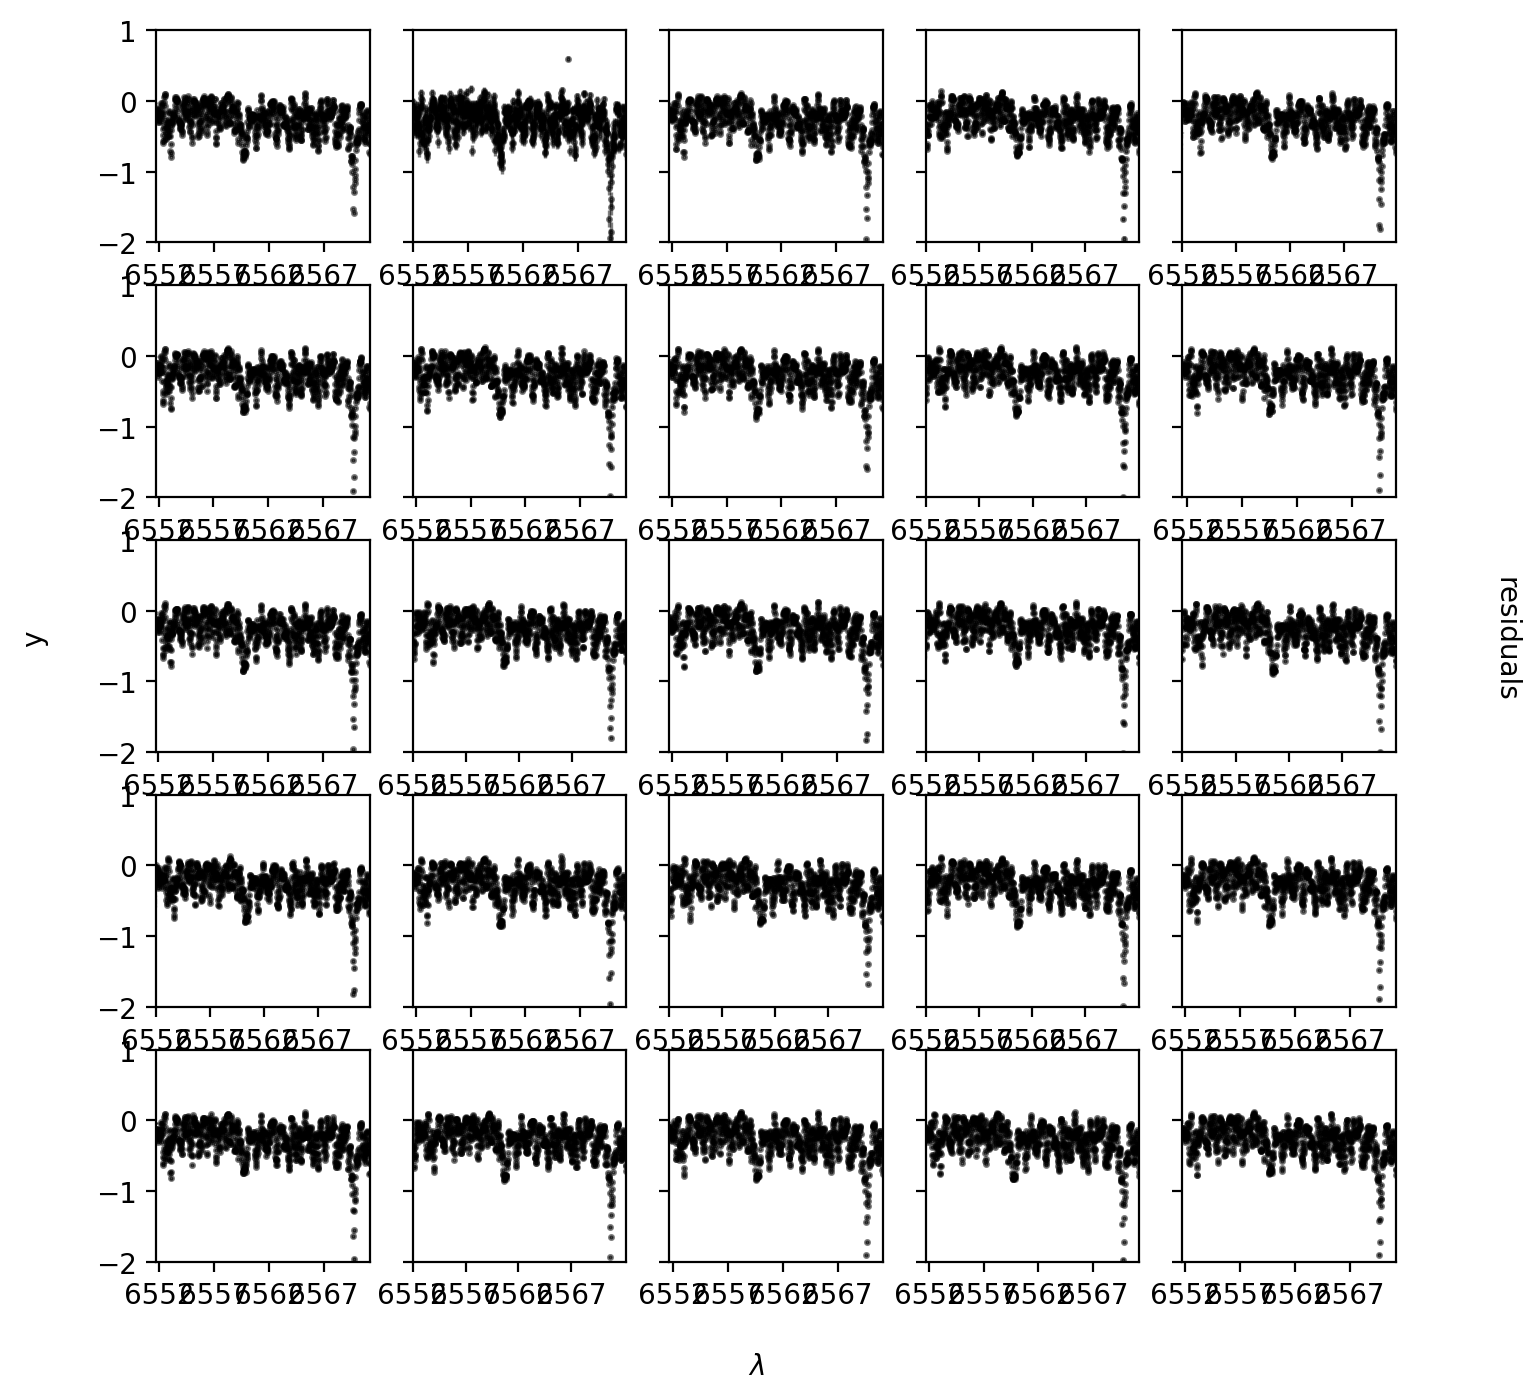

In [17]:
make_plot(model_b,dataset_b,shifts_b)

In [18]:
def train_cycle(model, dataset, loss):
    n_cycles = 3

    options1 = {"pgtol": 0.0}
    options2 = {"pgtol": 0.0}
    for iii in range(n_cycles):

        # model.fix()
        # model.fit(2)
        # res1 = model.optimize(loss, dataset, options=options1)
        # print(res1["warnflag"], res1["nit"])
        # if res1["warnflag"] == 2:
        #     print(res1["task"])

        model.fix()
        model.fit(0, 1)
        model.fit(1, 0)
        res1 = model.optimize(loss, dataset, options=options2)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

        model.fix()
        model.fit(0, 0)
        res1 = model.optimize(loss, dataset, options=options1)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

        model.fix()
        shift_search = jabble.physics.shifts(np.linspace(-10, 10, 100))
        model[0][0].parabola_fit(shift_search, loss, model, dataset)

        model.fix()
        model.fit(0, 0)
        model.fit(0, 1)
        model.fit(1, 0)
        res1 = model.optimize(loss, dataset, options=options2)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

        model.fix()
        model.fit(1, 1)
        res1 = model.optimize(loss, dataset, options=options2)
        print(res1["warnflag"], res1["nit"])
        if res1["warnflag"] == 2:
            print(res1["task"])

    return model

In [ ]:
model_p = train_cycle(model_p, dataset_p, loss)
model_b = train_cycle(model_b, dataset_b, loss)

5577 night sky line

In [ ]:
# modelname = 'barnardsvmapmodel1.mdl'
# # model = jabble.model.load(modelname)
# jabble.model.save(modelname,model)

In [ ]:
def make_plot(model,dataset,init_shifts,filename):
    x_window = np.log(4550) - np.log(4549)
    lmin = np.exp(dataset.xs[0,500])
    lmax = np.exp(dataset.xs[0,1500])
    lrange = np.arange(lmin,lmax,5)
    plt_unit = u.Angstrom
    epoches = 25
    r_plots = 5

    vel_epoch = 5
    fig, axes = plt.subplots(
        epoches // r_plots,
        r_plots,
        figsize=(8, 8),
        sharex=False,
        sharey=True,
        facecolor=(1, 1, 1),
        dpi=200,
    )
    # fig.suptitle(filenames[model_num])
    for plt_epoch in range((epoches // r_plots) * r_plots):
        xplot = np.linspace(np.log(lmin), np.log(lmax), dataset.xs.shape[1] * 10)
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(
            xplot.min() + model[0][0].p[plt_epoch],
            xplot.max() + model[0][0].p[plt_epoch],
        )

        # model_set[model_num].fix()
        # model_set[model_num].fit(0)
        # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),dataset.xs[plt_epoch,:],plt_epoch)
        # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])

        model.fix()

        axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(
            dataset.xs[plt_epoch, :],
            dataset.ys[plt_epoch, :],
            dataset.yerr[plt_epoch, :],
            fmt=".k",
            elinewidth=1.2,
            zorder=1,
            alpha=0.5,
            ms=3,
        )

        # true_model.fix()

        axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(
            xplot,
            model([], xplot, plt_epoch),
            "-r",
            linewidth=1.2,
            zorder=2,
            alpha=0.5,
            ms=6,
        )
        # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)

        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2, 1)
        #         axes[i,j].set_yticks([])
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(
            ["{:2.0f}".format(x) for x in lrange]
        )

        res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
        residual = loss(
            model.get_parameters(),
            dataset,
            plt_epoch,
            model,
        )
        res_ax.step(
            dataset.xs[plt_epoch, :], residual, where="mid", alpha=0.3, label="residual"
        )
        res_ax.set_ylim(0.0, 20)
        res_ax.set_yticks([])
        # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
        #             model_set[i][j].results[-2]['grad'][:],\
        #             where='mid',alpha=0.4,label='residual',zorder=-1)
        # res_ax.set_yticks([])

        # res_ax.step(x_grid,\
        #             rv_model_deriv[:,plt_epoch],\
        #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

        #     res_ax.step(x_grid,\
        #                 rv_loss_deriv[:,plt_epoch],\
        #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)

        #     align_yaxis(, 0, , 0)

        align.yaxes(
            axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2.0 / 3.0
        )

    # res.get_shared_y_axes().join(ax1, ax3)
    fig.text(0.5, 0.04, "$\lambda$", ha="center")
    fig.text(0.04, 0.5, "y", va="center", rotation="vertical")
    # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
    # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
    fig.text(0.96, 0.5, "residuals", va="center", rotation=270)

    plt.savefig(
        os.path.join(out_dir, "02-res_{}.png".format(filename)),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

6563 h alpha

In [ ]:
filenames = ['51peg','barnards']
make_plot(model_b,dataset_b,shifts_b,filenames[1])

In [ ]:
def rv_plot(model_set,datasets,shift_set,filenames,file_set):
    fig, ax = plt.subplots(
        len(model_set),
        figsize=(8, 8),
        facecolor=(1, 1, 1),
        dpi=300,
        sharey=True,
    )
     
    for i in range(len(model_set)):
        velocities = jabble.physics.velocities(shift_set[i]) * u.m/u.s
        epoches = datasets[i].xs.shape[0]
        epoch_range = np.arange(0, epoches, dtype=int)
        fischer_information = np.zeros(epoches)
        for e_num in range(epoches):
            model_set[i].fix()
            model_set[i].fit(0,0)
            temp = jax.jacfwd(model_set[i], argnums=0)(model_set[i].get_parameters(),datasets[i].xs[e_num,:],e_num)
            # print(temp.shape)
            fischer_information[e_num] = jnp.dot(
                temp[:, e_num] ** 2, datasets[i].yivar[e_num, :]
            )
    
        dvddx = jnp.array(
            [jax.grad(jabble.physics.velocities)(x) for x in model_set[i][0][0].p]
        )
        verr = np.sqrt(1 / fischer_information) * dvddx
        estimate_vel = jabble.physics.velocities(model_set[i][0][0].p)
        tv = velocities.to(u.m/u.s).value - velocities.to(u.m/u.s).value.mean()
        ev = estimate_vel - estimate_vel.mean()
        ax[i].errorbar(
            epoch_range,
            tv - tv,
            yerr=file_set[i]["pipeline_sigmas"][:],
            fmt=".r",
            elinewidth=2.2,
            zorder=1,
            alpha=0.5,
            ms=6,
        )
    
        ax[i].errorbar(epoch_range,tv - ev,yerr=verr,fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    
        ax[i].set_title('{}'.format(filenames[i], model_set[i][1][0].p_val))
        ax[i].set_xlim(-0.5, epoches - 0.5)
    fig.text(0.04, 0.5, "$v_{truth} - v_{est}$ [$m/s$]", va="center", rotation="vertical")
    fig.text(0.5, 0.04, "epochs", ha="center")
    plt.savefig(os.path.join(out_dir, "02-dv-barn-51peg.png"))
    plt.show()

In [ ]:
model_set = [model_p,  model_b]
datasets  = [dataset_p,dataset_b]
shift_set = [shifts_p, shifts_b]
file_set  = [file_p,   file_b]
rv_plot(model_set,datasets,shift_set,filenames,file_set)

In [ ]:
def make_better_plot(model_set,datasets,file_set):
    

    fig, axes = plt.subplots(2*len(model_set),4,figsize=(4*4,4*len(model_set)),sharex=True,facecolor=(1, 1, 1),dpi=200,height_ratios=[4,1]*len(model_set))
    
    for jj,(model,dataset,file) in enumerate(zip(model_set,datasets,file_set)):
        x_window = np.log(4550) - np.log(4549)
        lmin = np.exp(dataset.xs[0,0])
        lmax = np.exp(dataset.xs[0,2000])
        lrange = np.arange(lmin,lmax,5)
        sort_airmasses = np.argsort(np.array(file['airms'][:]))
        plt_epochs = np.concatenate((sort_airmasses[:2],sort_airmasses[-2:]))
        
        
        
        
        offset = 1.0
        xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset.xs.shape[1]*10)
        for ii,plt_epoch in enumerate(plt_epochs):
            axes[2*jj,ii].set_xlim(xplot.min()+model[0][0].p[plt_epoch],xplot.max()+model[0][0].p[plt_epoch])
            
            model.fix()
            
            axes[2*jj,ii].errorbar(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:],\
                                     dataset.yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)
            
            axes[2*jj,ii].plot(xplot,offset + model[0]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            axes[2*jj,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            axes[2*jj,ii].plot(xplot,model[2]([],xplot,plt_epoch),'-m',linewidth=1.2,zorder=3,alpha=0.7,ms=6)
            
            # axes[0,ii].plot(xplot,2*offset + model[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            # axes[0,ii].plot(xplot,offset + model([],xplot,plt_epoch),'-g',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
            # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
            
            
            axes[2*jj,ii].set_ylim(-2,3)
            axes[2*jj,ii].set_xticks([])
            # axes[0].set_yticks([])
            axes[2*jj+1,ii].set_xticks(np.log(lrange))
            axes[2*jj+1,ii].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
            
            axes[2*jj+1,ii].plot(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:] - model([],dataset.xs[plt_epoch,:],plt_epoch),'.k',alpha=0.4,ms=1)
            
            axes[2*jj+1,ii].set_ylim(-0.1,0.1)
            axes[2*jj,ii].set_title('airmass = {}'.format(file['airms'][:][plt_epoch]))
        # res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
        # residual = loss(model_set[model_num].get_parameters(),dataset,plt_epoch,model_set[model_num])
        # res_ax.step(dataset.xs[plt_epoch,:],residual,where='mid',alpha=0.3,label='residual')
        # res_ax.set_ylim(0.0,20)
        # res_ax.set_yticks([])
        # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
        #             model_set[i][j].results[-2]['grad'][:],\
        #             where='mid',alpha=0.4,label='residual',zorder=-1)
        # res_ax.set_yticks([])
        
        # res_ax.step(x_grid,\
        #             rv_model_deriv[:,plt_epoch],\
        #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
        #     res_ax.step(x_grid,\
        #                 rv_loss_deriv[:,plt_epoch],\
        #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
            
        #     align_yaxis(, 0, , 0)
            
            # align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)
        
        # res.get_shared_y_axes().join(ax1, ax3)
        fig.text(0.5, 0.04, '$\lambda$', ha='center')
        # fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
        # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
        # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
        # fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
    plt.savefig(os.path.join(out_dir,'02-full-barn-51peg.png'),dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
make_better_plot(model_set,datasets,file_set)

In [ ]:
file_set

In [ ]:
tell_loss = [[],[]]
for jjj, (dataset, model) in enumerate(zip(datasets,model_set)):
    for iii in range(dataset.ys.shape[0]):
        tell_loss[jjj].append(loss([],dataset,iii,model[0]).sum())

plt.plot(np.array(file_p['airms'][:]),tell_loss[0],'.k',label='51 peg')
plt.plot(np.array(file_b['airms'][:]),tell_loss[1],'.r',label='barnards')
# plt.ylim(0.0,5e4)

# plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
# plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
plt.xlabel('airmass')
plt.ylabel('$\Sigma_* (y_* - \hat{y}_s(x_*)) I_{y*}$')
# plt.plot()
plt.legend()
plt.savefig(os.path.join(out_dir,'02-airmass_loss.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(np.array(file_p['airms'][:]),model_p[1][1].p,'.k',label='51 peg')
plt.plot(np.array(file_b['airms'][:]),model_b[1][1].p,'.r',label='barnards')
plt.xlabel('airmass')
plt.ylabel('~a')
x_space = np.linspace(np.min(np.array(file_b['airms'][:])),np.max(np.array(file_b['airms'][:])))
plt.plot(x_space,x_space,'-.k',alpha=0.3)
plt.legend()
plt.savefig(os.path.join(out_dir,'02-airmass_an.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(1,figsize=(4,4),sharex=True,facecolor=(1, 1, 1),dpi=200)

plt_epoch = 10
x_window = np.log(4550) - np.log(4549)
lmin = np.exp(dataset_p.xs[0,500])
lmax = np.exp(dataset_p.xs[0,1500])
lrange = np.arange(lmin,lmax,5)
xplot = np.linspace(np.log(lmin)-x_window,np.log(lmax)+x_window,dataset_p.xs.shape[1]*10)
axes.plot(xplot,model_p[1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='51 peg')
axes.plot(xplot,0.05 + model_b[1]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.6,ms=6,label='barnard')
axes.legend()

axes.set_ylim(-0.2,0.1)
axes.set_xticks([])
axes.set_ylabel('log flux + offset')
axes.set_xlabel('$\lambda$')
axes.set_xticks(np.log(lrange))
axes.set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
plt.title('just tellurics')
plt.savefig(os.path.join(out_dir,'02-airmass-tell.png'),dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# model_p.fix()
# model_p.fit(0,1)
# e_num = 0
# dudth = jax.jacfwd(model_p, argnums=0)(model_p.get_parameters(),dataset_p.xs[e_num,:],e_num)
# ith   = dudth * dataset.yivar * dudth.T
# print(dudth)

In [ ]:
def variation_info(self,model,dataset):
    f_info = np.zeros(dataset.xs.shape)
    model.fix()
    self.fit()
    for e_num in range(dataset.xs.shape[0]):
        duddx = jax.jacfwd(model, argnums=0)(model.get_parameters(),dataset.xs[e_num,:],e_num)
        f_info[e_num,:] =  jnp.dot(duddx[:,e_num]**2,dataset.yivar[e_num,:])
    return f_info